In [79]:
import json
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Step 1: Load JSON data
# -------------------------------
with open("bcs_dataset_with_filenames.json", "r") as f:
    data = json.load(f)

print("Total entries in JSON:", len(data))


Total entries in JSON: 100


In [80]:
view_to_folder = {
    "ภาพด้านบน (Top View)": "Top View",
    # "ภาพด้านหลัง (Back View)": "Back View",
    # "ภาพด้านขวา (Right View)": "Right View",
    # "ภาพด้านซ้าย (Left View)": "Left View"
}

from PIL import Image, UnidentifiedImageError
import numpy as np
import os
from tensorflow.keras.preprocessing.image import img_to_array

images = []
labels = []

view_fields = [
    "ภาพด้านบน (Top View)",
    # "ภาพด้านหลัง (Back View)",
    # "ภาพด้านขวา (Right View)",
    # "ภาพด้านซ้าย (Left View)"
]

# map field -> folder
view_to_folder = {
    "ภาพด้านบน (Top View)": "Top View",
    # "ภาพด้านหลัง (Back View)": "Back View",
    # "ภาพด้านขวา (Right View)": "Right View",
    # "ภาพด้านซ้าย (Left View)": "Left View"
}

base_dir = "bcs_images"  # โฟลเดอร์หลัก

for entry in data:
    bcs_value = entry["ค่า BCS (โปรดระบุเป็นตัวเลข)"]

    if not str(bcs_value).isdigit():
        continue
    bcs_value = int(bcs_value)

    for view in view_fields:
        filename = entry.get(view, "").strip()  # ตอนนี้เก็บเป็นชื่อไฟล์ เช่น img1.jpg
        if filename:
            img_path = os.path.join(base_dir, view_to_folder[view], filename)
            if os.path.exists(img_path):
                try:
                    with Image.open(img_path) as img:
                        img = img.convert("RGB")
                        img = img.resize((224, 224))
                        img_array = img_to_array(img) / 255.0
                        images.append(img_array)
                        labels.append(bcs_value)
                except UnidentifiedImageError:
                    print(f"⚠️ {img_path} is not a valid image file (skip)")
                except Exception as e:
                    print(f"⚠️ Error loading {img_path}: {e}")
            else:
                print(f"⚠️ Missing file: {img_path}")

X_test = np.array(images, dtype="float32")
y_test_raw = np.array(labels, dtype="int")

print("✅ Total test images loaded:", len(X_test))
print("✅ Unique BCS labels:", np.unique(y_test_raw))


✅ Total test images loaded: 92
✅ Unique BCS labels: [2 3 4 5 6 7 8 9]


In [81]:

# -------------------------------
# Step 3: Adjust labels (map BCS 1–9 -> 0–8)
# -------------------------------
y_test_adj = y_test_raw - 1   # เช่น BCS=1 → class=0, BCS=9 → class=8

# -------------------------------
# Step 4: Load trained model
# -------------------------------
model = load_model("bcs_prediction_model.h5")


In [82]:

# -------------------------------
# Step 5: Predict
# -------------------------------
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)



3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step


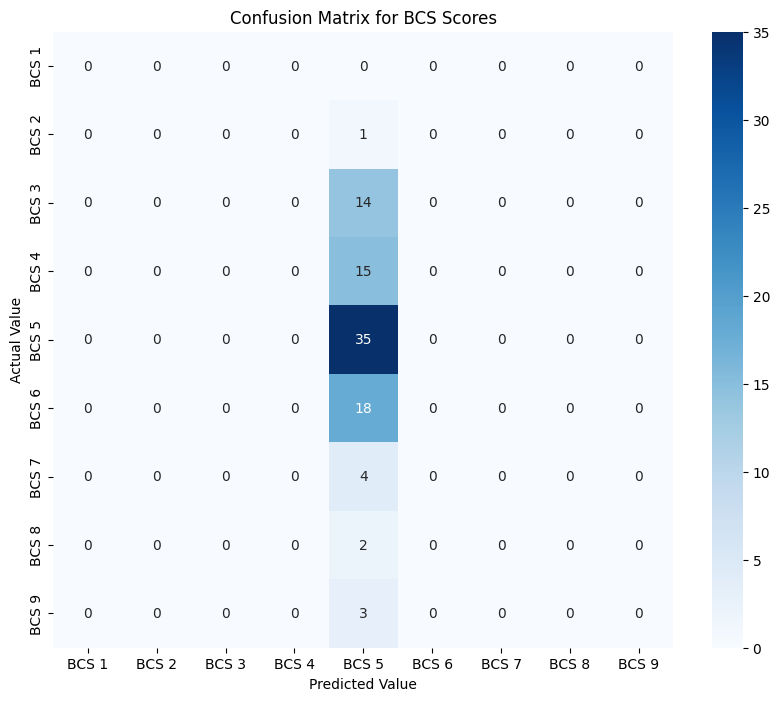

In [83]:

# -------------------------------
# Step 6: Confusion Matrix
# -------------------------------
all_labels = list(range(9))  # 0-8 (แทน BCS 1–9)

cm = confusion_matrix(y_test_adj, y_pred, labels=all_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"BCS {i}" for i in range(1, 10)],
            yticklabels=[f"BCS {i}" for i in range(1, 10)])
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.title("Confusion Matrix for BCS Scores")
plt.show()


In [84]:
# -------------------------------
# Step 7: Classification Report
# -------------------------------
print("\nClassification Report:")
print(classification_report(
    y_test_adj, y_pred,
    labels=all_labels,
    target_names=[f"BCS {i}" for i in range(1, 10)],
    zero_division=0
))


Classification Report:
              precision    recall  f1-score   support

       BCS 1       0.00      0.00      0.00         0
       BCS 2       0.00      0.00      0.00         1
       BCS 3       0.00      0.00      0.00        14
       BCS 4       0.00      0.00      0.00        15
       BCS 5       0.38      1.00      0.55        35
       BCS 6       0.00      0.00      0.00        18
       BCS 7       0.00      0.00      0.00         4
       BCS 8       0.00      0.00      0.00         2
       BCS 9       0.00      0.00      0.00         3

    accuracy                           0.38        92
   macro avg       0.04      0.11      0.06        92
weighted avg       0.14      0.38      0.21        92



In [85]:
from sklearn.metrics import accuracy_score

# -------------------------------
# Accuracy
# -------------------------------
accuracy = accuracy_score(y_test_adj, y_pred)
print(f"\n✅ Accuracy on Top View test set: {accuracy*100:.2f}%")



✅ Accuracy on Top View test set: 38.04%
